# Preparation

In [1]:
import csv
import regex
import datetime as dt
from datetime import timedelta
import locale
locale.setlocale(locale.LC_TIME, 'id-ID.UTF-8')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist
from kneed import KneeLocator
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

import warnings
warnings.filterwarnings("ignore")
#from feature_engine.outlier_removers import Winsorizer

In [103]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column], kde=False)
    
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

def norm_minmax(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

def kmeans(normalised_df_lrfm, clusters_number, original_df_lrfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_lrfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_lrfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

def snake_plot(normalised_df_lrfm, df_lrfm_kmeans, df_lrfm_original):

    normalised_df_lrfm = pd.DataFrame(normalised_df_lrfm, 
                                       index=df_lrfm_original.index, 
                                       columns=df_lrfm_original.columns)
    normalised_df_lrfm['Cluster'] = df_lrfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_lrfm.reset_index(), 
                        id_vars=['telp', 'Cluster'],
                        value_vars=['Length', 'Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

def threeD_plot(df_lrfm_kmeans, df_lrfm_original):
    from mpl_toolkits.mplot3d import Axes3D
    
    df_merge = pd.merge(df_lrfm_kmeans, df_lrfm_original['Cluster'], on='telp', how='left')

    x = np.array(df_merge['Recency'])
    y = np.array(df_merge['Frequency'])
    z = np.array(df_merge['Monetary'])

    plt.xlabel('Recency')
    plt.ylabel('Frequency')
    # plt.zlabel('Monetary')  
    ax.legend('Cluster')
    ax.scatter(x,y,z, s=(df_merge['Length']*40), marker="s", c=df_merge["Cluster"], cmap="Paired")


    return

## Import dataset

In [3]:
df = pd.read_csv("Coret-Coret Marketing_Transaction Details (TA Hammam)_2003-2105.csv")
# df = pd.read_csv("Coret-Coret Marketing_Transaction Details (TA Hammam)_1904-2104.csv")
display(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57098 entries, 0 to 57097
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   delivery_date     57098 non-null  object 
 1   delivery_status   57098 non-null  object 
 2   no_order          57098 non-null  object 
 3   Channel           57098 non-null  object 
 4   transaction_type  57098 non-null  object 
 5   ID CL             33394 non-null  float64
 6   nama_komunitas    29526 non-null  object 
 7   name              57098 non-null  object 
 8   username          57080 non-null  object 
 9   useremail         57080 non-null  object 
 10  telp              57021 non-null  object 
 11  prod_id           56358 non-null  float64
 12  produk            56358 non-null  object 
 13  harga             57098 non-null  float64
 14  qty               57098 non-null  float64
 15  subtotal          57098 non-null  float64
dtypes: float64(5), object(11)
memory usage: 

None

delivery_date delivery_status no_order   Channel transaction_type  ID CL  \
0    2 Mar 2020       delivered  Z39CJIP  End User           normal    NaN   
1    2 Mar 2020       delivered  Z39CJIP  End User           normal    NaN   
2    2 Mar 2020       delivered  Z39CJIP  End User           normal    NaN   
3    2 Mar 2020       delivered  Z39CJIP  End User           normal    NaN   
4    2 Mar 2020       delivered  Z39EJQS  End User           normal    NaN   
5    2 Mar 2020       delivered  Z39EJQS  End User           normal    NaN   
6    2 Mar 2020       delivered  Z39H8ES  End User           normal    NaN   
7    2 Mar 2020       delivered  Z39HQYJ  End User           normal    NaN   
8    2 Mar 2020       delivered  Z39HUHM  End User           normal    NaN   
9    2 Mar 2020       delivered  Z39JDVP  End User           normal    NaN   

  nama_komunitas                          name               username  \
0            NaN                Event PKK RW 7  Ternakfresh Indonesia   
1            NaN                Event PKK RW 7  Ternakfresh Indonesia   
2            NaN                Event PKK RW 7  Ternakfresh Indonesia   
3            NaN                Event PKK RW 7  Ternakfresh Indonesia   
4            NaN                        Fahrul  Ternakfresh Indonesia   
5            NaN                        Fahrul  Ternakfresh Indonesia   
6            NaN                      Bu Wahyu  Ternakfresh Indonesia   
7            NaN                     Mpok Sari  Ternakfresh Indonesia   
8            NaN  Bu Sri Pasar Menur Pumpungan  Ternakfresh Indonesia   
9            NaN                  Mida Asyafii           Mida Asyafii   

                useremail          telp  prod_id  \
0    ternakmart@gmail.com  081381306699    177.0   
1    ternakmart@gmail.com  081381306699    179.0   
2    ternakmart@gmail.com  081381306699    159.0   
3    ternakmart@gmail.com  081381306699    147.0   
4    ternakmart@gmail.com  081381306699     47.0   
5    ternakmart@gmail.com  081381306699     60.0   
6    ternakmart@gmail.com  081331122428    169.0   
7    ternakmart@gmail.com  081381306699    154.0   
8    ternakmart@gmail.com  081381306699    154.0   
9  mida.asyafii@gmail.com  628121619805     47.0   

                                           produk     harga  qty  subtotal  
0             DAGING AYAM KARKAS 800GR PARTING 10   28000.0  4.0  112000.0  
1                        DAGING AYAM KARKAS 900GR   30000.0  1.0   30000.0  
2                      DAGING AYAM FILLET DADA KG   87500.0  1.0   87500.0  
3  TELUR AYAM NEGERI PREMIUM 1PACK (ISI 10 BUTIR)   17500.0  4.0   70000.0  
4                     JABMILK SUSU RASA COKLAT 1L   20000.0  1.0   20000.0  
5        JAB YOGURT STROBERI 250ML [DISCONTINUED]    8000.0  1.0    8000.0  
6               DAGING AYAM KARKAS 1KG PARTING 12   33000.0  2.0   66000.0  
7                          TELUR AYAM NEGERI 10KG  230000.0  1.0  230000.0  
8                          TELUR AYAM NEGERI 10KG  230000.0  1.0  230000.0  
9                     JABMILK SUSU RASA COKLAT 1L   20000.0  1.0   20000.0

In [4]:
print("Dataset dimension : " + str(df.shape))
print('Jumlah Customer : ' + str(len(pd.unique(df['telp']))))
print('Jumlah Transaksi : ' + str(len(pd.unique(df['no_order']))))

Dataset dimension : (57098, 16)
Jumlah Customer : 4040
Jumlah Transaksi : 23134


# Cleaning

## Clean Telp

In [5]:
#Drop Null
df.dropna(subset=['telp', 'produk', 'name'], inplace=True)

#standarize telp number
df['telp'] = df['telp'].str.replace('-','')
df['telp'] = df['telp'].str.replace(' ','')
df['telp'] = df['telp'].str.replace('+','')
df['telp'] = df['telp'].str.replace('08', '628', 1)
df = df[df['telp'].str.startswith('628')]

#Clean admin no hp & Invalid
df = df.drop(df[df.telp.eq('6281381306699')
                | df.telp.eq('0')].index)
df = df[~df['telp'].str.contains('1234567')] #<--- Belum Bisa

#drop number with invalid character
df = df.drop(df[df.telp.str.contains(r'[^0-9a-zA-Z]')
                | df.telp.str.contains(r'[a-zA-Z]')].index)
                
#drop abnormal telpon length
df = df[df['telp'].str.len() > 10]
df = df[df['telp'].str.len() < 15]

## Clean Name, Channel, Product

In [44]:
#Clean penyesuaian dan test
testing = ['test', 'COBAAA', 'tes123', 'TEXTING', 'penyesuaian', 'penyelamatan']
df = df[~df['name'].str.contains('|'.join(testing))]

#Clean Old B2B Customer
B2B_cust = ['hotel', 'resto', 'restoran', 'cafe', 'coffee', 'Toko', 'toko', 'Patata', 'Geprek', 'Laziza', 'ayam', 'nasi', 'sego', 'Baksoe', 'Bakso', 'Rismart', 'Nu Mart', 'Warung', 'Rice box','E-Warung', 'ewarung', 'Kedai', 'geprek', 'nelongso', 'pkk', 'pkh']
df = df[~df['name'].str.contains('|'.join(B2B_cust))] 

#Clean B2B Product
B2Bproduct = ['B2B']
df = df[~df['produk'].str.contains('|'.join(B2Bproduct))] 

#Clean Based on Channel
channel = ['CL', 'End User', 'Shopee']
df = df[df['Channel'].isin(channel)]

#Clean Produk Promo & Bundling
Promo = ['PROMO', 'MAM', 'JSM', 'JUARA', 'PESTA', 'GRATIS', 'PAKET', 'SALE', 'PSBB']
df = df[~df['produk'].str.contains('|'.join(Promo))] 

#clean status non delivered
df = df[df.delivery_status.eq('delivered')]

#Cleaning outlier (Paket donasi sembako dan grosir)
## need futher data based technique
donasi = ['donasi', 'garda', 'sembako', 'psbb ']
df = df[~df['name'].str.contains('|'.join(testing))]
df = df[~(df['subtotal'] > 1000000)]
df = df[(df['harga'] > 0)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26238 entries, 6 to 56986
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   delivery_date     26238 non-null  object 
 1   delivery_status   26238 non-null  object 
 2   no_order          26238 non-null  object 
 3   Channel           26238 non-null  object 
 4   transaction_type  26238 non-null  object 
 5   ID CL             20662 non-null  float64
 6   nama_komunitas    18825 non-null  object 
 7   name              26238 non-null  object 
 8   username          26235 non-null  object 
 9   useremail         26235 non-null  object 
 10  telp              26238 non-null  object 
 11  prod_id           26238 non-null  float64
 12  produk            26238 non-null  object 
 13  harga             26238 non-null  float64
 14  qty               26238 non-null  float64
 15  subtotal          26238 non-null  float64
dtypes: float64(5), object(11)
memory usage: 

In [45]:
print("Dataset dimension : " + str(df.shape))
print('Jumlah Customer : ' + str(len(pd.unique(df['telp']))))
print('Jumlah Transaksi : ' + str(len(pd.unique(df['no_order']))))

Dataset dimension : (26238, 16)
Jumlah Customer : 2895
Jumlah Transaksi : 10164


In [46]:
df.to_csv("Ternakmart_Transaction_CLEAN.csv")

In [47]:
#parse datetime format
df_clean = df.copy()
df_clean['delivery_date'] = df_clean['delivery_date'].apply(lambda x:dt.datetime.strptime(x,'%d %b %Y'))
df_clean.to_csv("Ternakmart_Transaction_CLEAN_V1.csv")
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26238 entries, 6 to 56986
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   delivery_date     26238 non-null  datetime64[ns]
 1   delivery_status   26238 non-null  object        
 2   no_order          26238 non-null  object        
 3   Channel           26238 non-null  object        
 4   transaction_type  26238 non-null  object        
 5   ID CL             20662 non-null  float64       
 6   nama_komunitas    18825 non-null  object        
 7   name              26238 non-null  object        
 8   username          26235 non-null  object        
 9   useremail         26235 non-null  object        
 10  telp              26238 non-null  object        
 11  prod_id           26238 non-null  float64       
 12  produk            26238 non-null  object        
 13  harga             26238 non-null  float64       
 14  qty               2623

# Generate LRFM

In [48]:
#group by invoice 
df_group = df_clean.groupby(['no_order', 'telp', 'delivery_date'], as_index = False).agg({'subtotal':'sum'})
df_group

no_order            telp delivery_date  subtotal
0      54SSR0QS6022   6281231631020    2020-10-28  238000.0
1      54SSR0QTWU05    628123250805    2020-10-28  180000.0
2      54SSR0QTX0Z7   6281330302020    2020-10-19  250800.0
3      54SSR0QV0512   6281234158275    2020-10-19   52000.0
4      54SSR0QV0735   6285648248736    2020-10-28   43000.0
...             ...             ...           ...       ...
10159       Z3CTCHO   6282141646333    2020-04-22  398000.0
10160       Z3CTETS    628112501890    2020-04-22  112000.0
10161      Z3CTLXE2   6281703224617    2020-03-30  317500.0
10162       Z3CTNNF   6281215123452    2020-04-23  334000.0
10163       Z3CUDLX  62812162062842    2020-04-22  231000.0

[10164 rows x 4 columns]

In [49]:
#Group By Telp
#Perform mapping to LRFM
snapshot_date = df_clean['delivery_date'].max() + timedelta(days=1)
lrfm = df_group.groupby(['telp']).agg(Length=('delivery_date', lambda x: (snapshot_date - x.min()).days),
                                   Recency=('delivery_date', lambda x: (snapshot_date - x.max()).days),
                                   Frequency=('no_order', 'count'),
                                   Monetary=('subtotal', 'sum'))
lrfm.to_csv("Ternakmart_Transaction_LRFM.csv")
display(lrfm)
lrfm.describe()

Length  Recency  Frequency   Monetary
telp                                                
6280912371723     252      252          1   210900.0
628111699469       66       66          1   165500.0
628112068550      426      426          1   185000.0
628112501890      412      344          9  1027000.0
628113002154      361      103          2   296000.0
...               ...      ...        ...        ...
628993972781      141       95          2    79800.0
628996788009      376      376          1    27000.0
628996930020      203      203          1    26100.0
628999046770      251      251          1   156000.0
628999348311      242      242          1    62000.0

[2895 rows x 4 columns]

Length      Recency    Frequency      Monetary
count  2895.000000  2895.000000  2895.000000  2.895000e+03
mean    211.386183   173.914335     3.510881  5.363195e+05
std     114.068346   112.300602    13.859142  2.392560e+06
min       1.000000     1.000000     1.000000  1.100000e+03
25%     126.000000    71.000000     1.000000  1.555000e+04
50%     203.000000   200.000000     1.000000  1.075000e+05
75%     280.000000   208.000000     2.000000  3.180000e+05
max     456.000000   456.000000   448.000000  5.567345e+07

In [34]:
#Check Outlier on Frequency
sns.boxplot(lrfm['Frequency'])

<AxesSubplot:xlabel='Frequency'>

In [50]:
lrfm = lrfm[~(lrfm['Frequency'] > 80)]
sns.boxplot(x=lrfm['Frequency'])

<AxesSubplot:xlabel='Frequency'>

In [51]:
# Plot all 4 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(4, 1, 1)
check_skew(lrfm,'Length')

plt.subplot(4, 1, 2)
check_skew(lrfm,'Recency')

plt.subplot(4, 1, 3)
check_skew(lrfm,'Frequency')

plt.subplot(4, 1, 4)
check_skew(lrfm,'Monetary')

plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)

Length's: Skew: 0.32782465587387516, : SkewtestResult(statistic=7.027589022365944, pvalue=2.1013274177703857e-12)
Recency's: Skew: 0.45989759884779596, : SkewtestResult(statistic=9.643694374968103, pvalue=5.2272118137768615e-22)
Frequency's: Skew: 6.944966937610276, : SkewtestResult(statistic=51.0599104977197, pvalue=0.0)
Monetary's: Skew: 7.213109575516881, : SkewtestResult(statistic=51.7380372162306, pvalue=0.0)


In [ ]:
#Frequency dan monetary skewnya ndak masuk akal

## Transformation & Normalization

Length's: Skew: 0.32782465587387516, : SkewtestResult(statistic=7.027589022365944, pvalue=2.1013274177703857e-12)
Recency's: Skew: -0.34041301266477836, : SkewtestResult(statistic=-7.28386417871069, pvalue=3.2439161221126784e-13)
Frequency's: Skew: 1.6729255531549487, : SkewtestResult(statistic=26.34205955280631, pvalue=6.328569881447856e-153)
Monetary's: Skew: -0.4380868842260576, : SkewtestResult(statistic=-9.22315665994117, pvalue=2.88479905079996e-20)


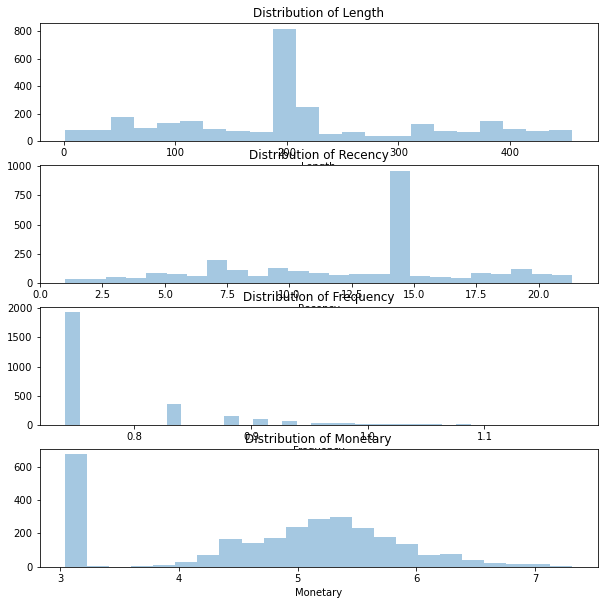

In [75]:
lrfm_trans = lrfm.copy()
#log10 Transformation
# lrfm_trans['Frequency'] = lrfm_trans['Frequency'].apply(lambda x: 1/x)
# lrfm_trans['Monetary'] = lrfm_trans['Monetary'].apply(lambda x: 1/x)

lrfm_trans['Recency'] = np.sqrt(lrfm_trans['Recency'])
lrfm_trans['Frequency'] = np.log10(lrfm_trans['Frequency']+1)
lrfm_trans['Monetary'] = np.log10(lrfm_trans['Monetary']+1)

lrfm_trans['Frequency'] = np.sqrt(lrfm_trans['Frequency'])

lrfm_trans['Frequency'] = np.sqrt(lrfm_trans['Frequency'])

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
check_skew(lrfm_trans,'Length')
plt.subplot(4, 1, 2)
check_skew(lrfm_trans,'Recency')
plt.subplot(4, 1, 3)
check_skew(lrfm_trans,'Frequency')
plt.subplot(4, 1, 4)
check_skew(lrfm_trans,'Monetary')

In [78]:
#Min-Max Normalization
norm_lrfm = norm_minmax(lrfm_trans)
norm_lrfm.describe()

Length      Recency    Frequency     Monetary
count  2885.000000  2885.000000  2885.000000  2885.000000
mean      0.461027     0.556742     0.130832     0.399342
std       0.250023     0.232463     0.217766     0.253778
min       0.000000     0.000000     0.000000     0.000000
25%       0.274725     0.367752     0.000000     0.265439
50%       0.443956     0.645673     0.000000     0.464057
75%       0.606593     0.659433     0.207963     0.575191
max       1.000000     1.000000     1.000000     1.000000

# K-Means Clustering

## Elbow Method

In [97]:
#Elbow Method
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(2,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(norm_lrfm) 
    kmeanModel.fit(norm_lrfm)     
      
    distortions.append(sum(np.min(cdist(lrfm, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / norm_lrfm.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(lrfm, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / lrfm.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

In [100]:

kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
print("Elbow at K =", kn.knee)

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.savefig('Grafik/Elbow Method using Distortion.png', format='png', dpi=1000)
plt.show()

Elbow at K = 4


Elbow at K = 4


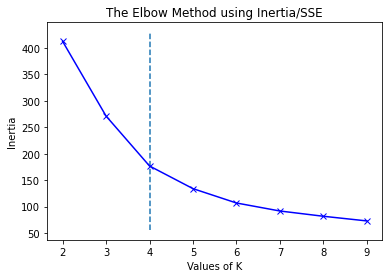

In [175]:
kn = KneeLocator(K, inertias, curve='convex', direction='decreasing')
print("Elbow at K =", kn.knee)

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia/SSE') 
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.savefig('Grafik/Elbow Method using Inertia.png', format='png', dpi=1000)
plt.show() 

## Silhouette Method

In [82]:
# Silhouette Method
euclidean = []
cosine = []
mapping_euclidean = {} 
K = range(1,10)

# Prepare models
for k in K: 
    kmeans = KMeans(n_clusters=6).fit(norm_lrfm)
    normalized_vectors = preprocessing.normalize(norm_lrfm)
    normalized_kmeans = KMeans(n_clusters=4).fit(normalized_vectors)
    min_samples = norm_lrfm.shape[1]+1

    euclidean.append(silhouette_score(norm_lrfm, kmeans.labels_, metric='euclidean'))
    cosine.append(silhouette_score(normalized_vectors, normalized_kmeans.labels_, metric='cosine'))

Highest Euclidean Value : 0.5222771294258499 at K=4


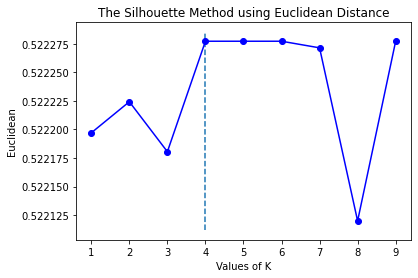

In [95]:
ymax = max(euclidean)
xpos = euclidean.index(ymax)
xmax = K[xpos]

print("Highest Euclidean Value : %s at K=%s" % (ymax, xmax,))
plt.plot(K, euclidean, 'bo-') 
plt.xlabel('Values of K') 
plt.ylabel('Euclidean') 
plt.title('The Silhouette Method using Euclidean Distance') 
plt.vlines(xmax, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.savefig('Grafik/Silhouette Method using Euclidean Distance.png', format='png', dpi=1000)
plt.show() 

Highest Cosine Value : 0.6663534819288105 at K=5


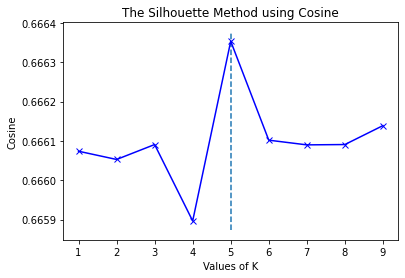

In [94]:
ymax = max(cosine)
xpos = cosine.index(ymax)
xmax = K[xpos]

print("Highest Cosine Value : %s at K=%s" % (ymax, xmax,))
plt.plot(K, cosine, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Cosine') 
plt.title('The Silhouette Method using Cosine') 
plt.vlines(xmax, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.savefig('Grafik/Silhouette Method using Cosine.png', format='png', dpi=1000)
plt.show() 

In [ ]:
# Silhouette Method
kmeans = KMeans(n_clusters=4).fit(norm_lrfm)
normalized_vectors = preprocessing.normalize(norm_lrfm)
normalized_kmeans = KMeans(n_clusters=4).fit(normalized_vectors)
min_samples = norm_lrfm.shape[1]+1

# Print results
print(silhouette_score(norm_lrfm, kmeans.labels_, metric='euclidean'))
print(silhouette_score(normalized_vectors, normalized_kmeans.labels_, metric='cosine'))

## Cluster!!

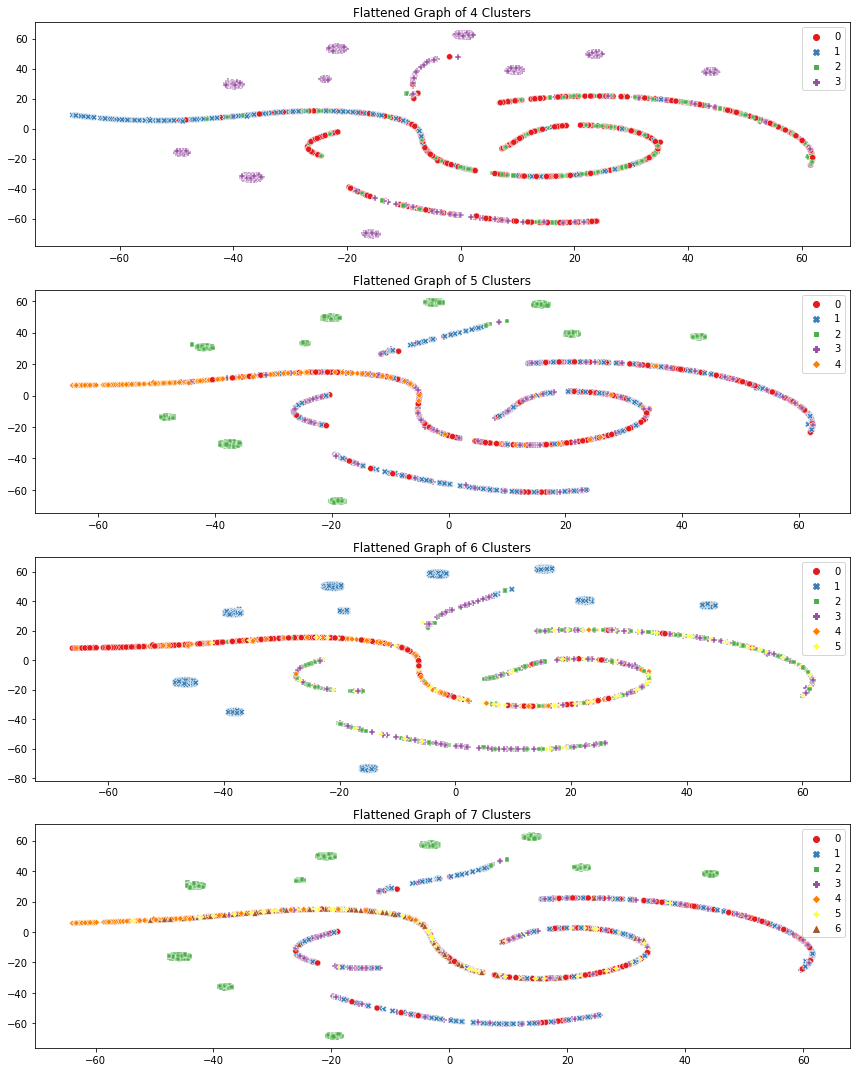

In [104]:
#Scatter Plot
plt.figure(figsize=(12, 15))

plt.subplot(4, 1, 1)
df_lrfm_k4 = kmeans(norm_lrfm, 4, lrfm)

plt.subplot(4, 1, 2)
df_lrfm_k5 = kmeans(norm_lrfm, 5, lrfm)

plt.subplot(4, 1, 3)
df_lrfm_k6 = kmeans(norm_lrfm, 6, lrfm)

plt.subplot(4, 1, 4)
df_lrfm_k7 = kmeans(norm_lrfm, 7, lrfm)

plt.tight_layout()
plt.savefig('Grafik/Cluster-flattened.png', format='png', dpi=300)

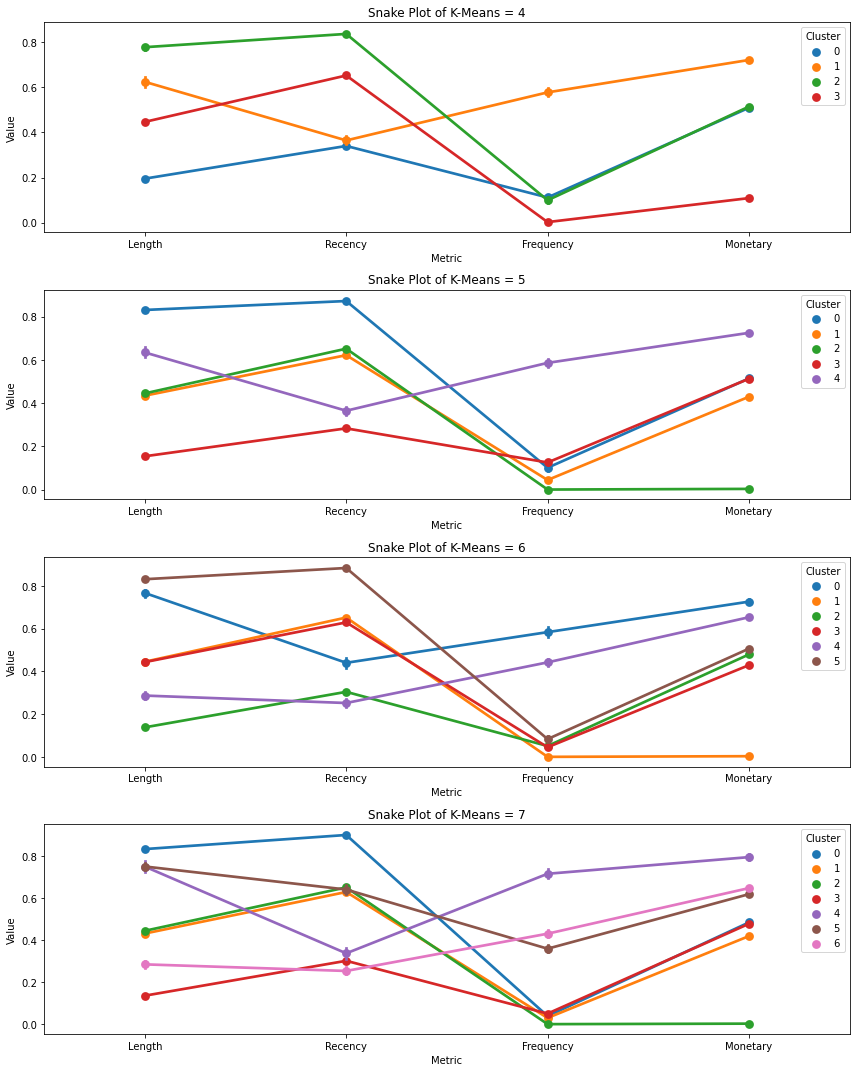

In [105]:
#Snake Plot
plt.figure(figsize=(12, 15))

plt.subplot(4, 1, 1)
plt.title('Snake Plot of K-Means = 4')
snake_plot(norm_lrfm, df_lrfm_k4, lrfm)

plt.subplot(4, 1, 2)
plt.title('Snake Plot of K-Means = 5')
snake_plot(norm_lrfm, df_lrfm_k5, lrfm)

plt.subplot(4, 1, 3)
plt.title('Snake Plot of K-Means = 6')
snake_plot(norm_lrfm, df_lrfm_k6, lrfm)

plt.subplot(4, 1, 4)
plt.title('Snake Plot of K-Means = 7')
snake_plot(norm_lrfm, df_lrfm_k7, lrfm)

plt.savefig('Grafik/Cluster-snakeplot.png', format='png', dpi=300)
plt.tight_layout()

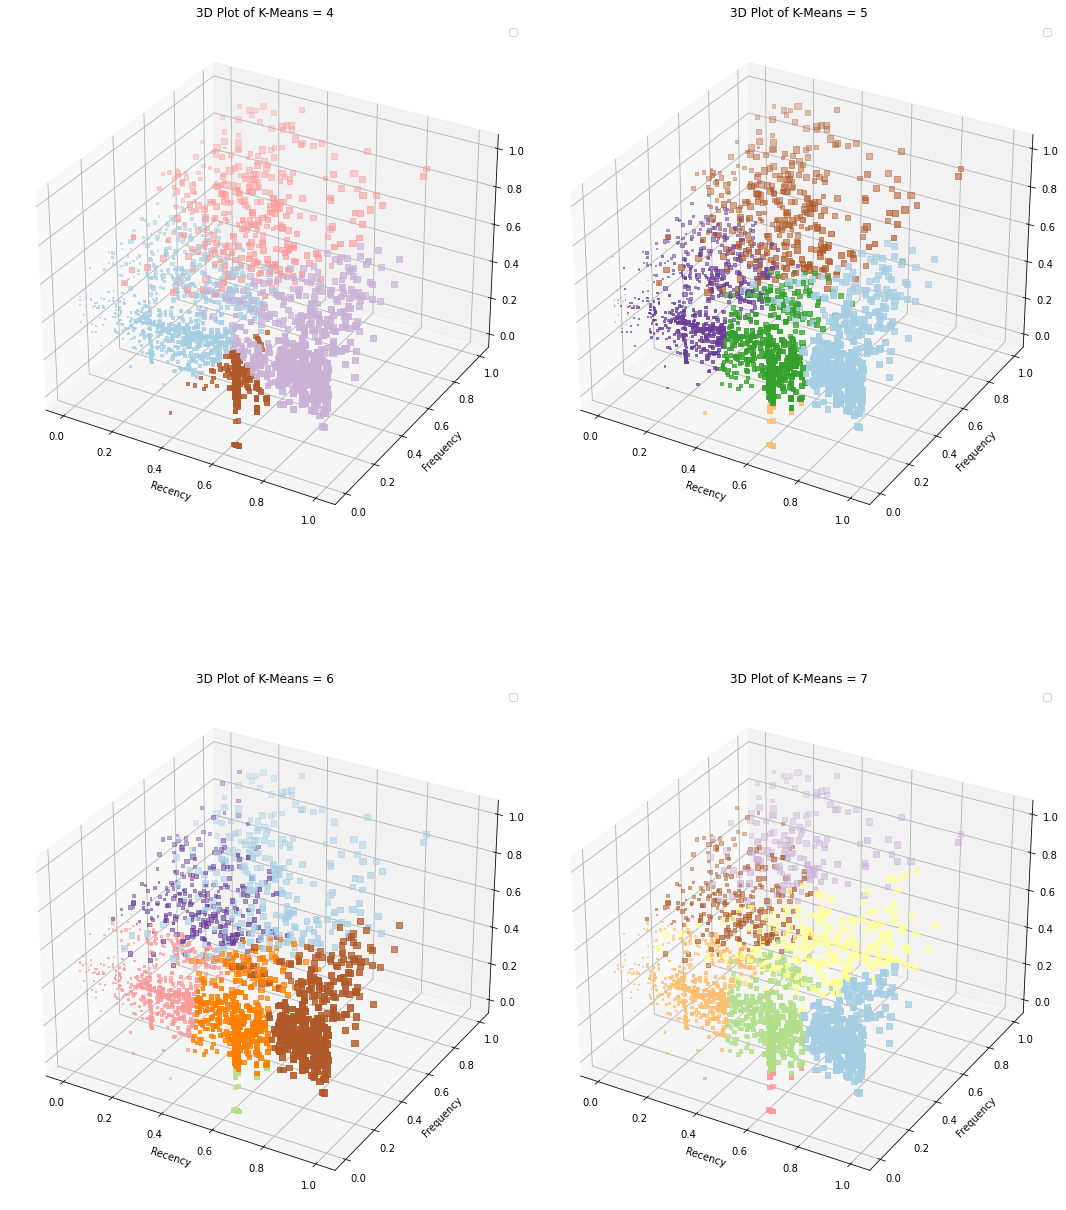

In [106]:
#3D Plot
fig = plt.figure(figsize=(15, 20))

ax = fig.add_subplot(2, 2, 1, projection='3d')
plt.title('3D Plot of K-Means = 4')
threeD_plot(norm_lrfm, df_lrfm_k4)

ax = fig.add_subplot(2, 2, 2, projection='3d')
plt.title('3D Plot of K-Means = 5')
threeD_plot(norm_lrfm, df_lrfm_k5)

ax = fig.add_subplot(2, 2, 3, projection='3d')
plt.title('3D Plot of K-Means = 6')
threeD_plot(norm_lrfm, df_lrfm_k6)

ax = fig.add_subplot(2, 2, 4, projection='3d')
plt.title('3D Plot of K-Means = 7')
threeD_plot(norm_lrfm, df_lrfm_k7)

plt.savefig('Grafik/Cluster-3DPlot.png', format='png', dpi=300)
plt.tight_layout()

In [107]:
#Pilih dataframe dengan jumlah cluster yang fix dipakai
df_cluster_fix = df_lrfm_k6.copy()

# Cluster Analysis

In [115]:
#Mengubah nilai Recency menggunakan 1-R karena merupakan kebalikan dari variabel lain
#R asli jika semakin kecil akan semakin bagus
df_lrfm_all = pd.merge(df_cluster_fix, norm_lrfm, on='telp', suffixes=('_real', '_norm'))
df_lrfm_all['Recency_norm'] = 1-df_lrfm_all['Recency_norm']
df_lrfm_all

Length_real  Recency_real  Frequency_real  Monetary_real  \
telp                                                                      
6280912371723          252           252               1       210900.0   
628111699469            66            66               1       165500.0   
628112068550           426           426               1       185000.0   
628112501890           412           344               9      1027000.0   
628113002154           361           103               2       296000.0   
...                    ...           ...             ...            ...   
628993972781           141            95               2        79800.0   
628996788009           376           376               1        27000.0   
628996930020           203           203               1        26100.0   
628999046770           251           251               1       156000.0   
628999348311           242           242               1        62000.0   

               Cluster  Length_norm  Recency_norm  Frequency_norm  \
telp                                                                
6280912371723        3     0.551648      0.269215        0.000000   
628111699469         2     0.142857      0.649996        0.000000   
628112068550         5     0.934066      0.035098        0.000000   
628112501890         0     0.903297      0.137904        0.596537   
628113002154         0     0.791209      0.550515        0.207963   
...                ...          ...           ...             ...   
628993972781         2     0.307692      0.570270        0.207963   
628996788009         5     0.824176      0.096464        0.000000   
628996930020         3     0.443956      0.349135        0.000000   
628999046770         3     0.549451      0.270764        0.000000   
628999348311         3     0.529670      0.284846        0.000000   

               Monetary_norm  
telp                          
6280912371723       0.534066  
628111699469        0.509430  
628112068550        0.520750  
628112501890        0.694942  
628113002154        0.568514  
...                      ...  
628993972781        0.435299  
628996788009        0.325170  
628996930020        0.321725  
628999046770        0.503422  
628999348311        0.409650  

[2885 rows x 9 columns]

In [129]:
def lrfm_values(df):
    lrfm_cluster = df.groupby(['Cluster']).agg({'mean'}).round(3)
    return lrfm_cluster

In [130]:
lrfm_values(df_lrfm_all)

Length_real Recency_real Frequency_real Monetary_real Length_norm  \
               mean         mean           mean          mean        mean   
Cluster                                                                     
0           349.670      114.459         13.893   2468070.213       0.766   
1           203.501      203.499          1.003      1215.942       0.445   
2            64.005       57.984          1.247    169817.278       0.138   
3           202.745      192.662          1.238    130434.941       0.443   
4           131.559       45.559          6.082    982186.594       0.287   
5           378.975      362.527          1.512    245864.777       0.831   

        Recency_norm Frequency_norm Monetary_norm  
                mean           mean          mean  
Cluster                                            
0              0.560          0.583         0.726  
1              0.348          0.001         0.004  
2              0.696          0.051         0.479  
3              0.371          0.046         0.429  
4              0.748          0.442         0.653  
5              0.117          0.084         0.506

In [128]:
df_lrfm_all.mean(axis=0).round(3)

Length_real          210.767
Recency_real         174.459
Frequency_real         2.881
Monetary_real     427408.795
Cluster                2.464
Length_norm            0.461
Recency_norm           0.443
Frequency_norm         0.131
Monetary_norm          0.399
dtype: float64

## Menghitung CLV

In [131]:
AHP = {
    'Length' : 0.52,
    'Recency' : 0.095,
    'Frequency' : 0.36,
    'Monetary' : 0.494}

count    2885.000000
mean        0.526217
std         0.244232
min         0.175691
25%         0.290057
50%         0.465318
75%         0.681940
max         1.382881
Name: CLV, dtype: float64

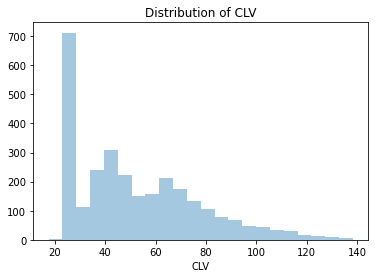

In [138]:
df_lrfm_all['CLV'] = (df_lrfm_all['Length_norm']*AHP['Length'] + df_lrfm_all['Recency_norm']*AHP['Recency'] + df_lrfm_all['Frequency_norm']*AHP['Frequency'] + df_lrfm_all['Monetary_norm']*AHP['Monetary'])
display(df_lrfm_all['CLV'].describe())

#Agar angka lebih cantik dan mudah dibaca, kita kalikan 1000
df_lrfm_all['CLV'] = df_lrfm_all['CLV']*100
plt.title('Distribution of CLV')
sns.distplot(df_lrfm_all['CLV'], kde=False)
plt.show()

## Rank CLV

In [139]:
def clv_values(df):
    clv_cluster = df.groupby(['Cluster']).agg({
        'Length_real': ['min', 'max', 'mean'],
        'Recency_real': ['min', 'max', 'mean'],
        'Frequency_real': ['min', 'max', 'mean'],
        'Monetary_real': ['min', 'max', 'mean'],
        'CLV' : 'mean'
    }).round(0)
    
    return clv_cluster

In [140]:
clv_values(df_lrfm_all).sort_values(by=[('CLV','mean')], ascending=False)

Length_real             Recency_real             Frequency_real      \
                min  max   mean          min  max   mean            min max   
Cluster                                                                       
0               206  456  350.0            3  362  114.0              2  80   
5               283  456  379.0          132  456  363.0              1   8   
4                 6  270  132.0            1  185   46.0              2  69   
3               117  355  203.0           68  287  193.0              1   4   
2                 1  153   64.0            1  126   58.0              1   3   
1                80  252  204.0           80  252  203.0              1   2   

              Monetary_real                           CLV  
         mean           min         max       mean   mean  
Cluster                                                    
0        14.0       94000.0  20664070.0  2468070.0  102.0  
5         2.0       12000.0   1924500.0   245865.0   72.0  
4         6.0      104000.0  12293428.0   982187.0   70.0  
3         1.0       10100.0   1140000.0   130435.0   49.0  
2         1.0        4000.0   1614500.0   169817.0   39.0  
1         1.0        1100.0      9100.0     1216.0   27.0

<AxesSubplot:xlabel='Length_real'>

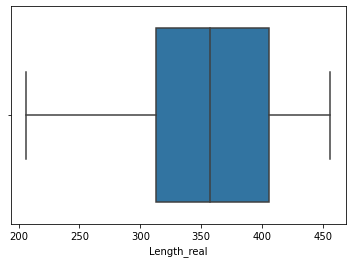

In [147]:
df_lrfm_c0 = df_lrfm_all[lambda x: x['Cluster'] == 0]
df_lrfm_c1 = df_lrfm_all[lambda x: x['Cluster'] == 1]
df_lrfm_c2 = df_lrfm_all[lambda x: x['Cluster'] == 2]
df_lrfm_c3 = df_lrfm_all[lambda x: x['Cluster'] == 3]
df_lrfm_c4 = df_lrfm_all[lambda x: x['Cluster'] == 4]
df_lrfm_c5 = df_lrfm_all[lambda x: x['Cluster'] == 5]

sns.boxplot(df_lrfm_c0['Length_real'])

# Market Basket Analysis

## Join Dataframe

In [174]:
df_basket_all = pd.merge(df_clean, df_cluster_fix, on='telp', how='left')
df_basket_all = df_basket_all[['delivery_date', 'no_order', 'telp', 'prod_id', 'produk', 'qty', 'Cluster']].copy()
df_basket_all['prod_id'] = df_basket_all['prod_id'].astype(int)

#drop NA from frequency outlier
df_basket_all.dropna(subset=['Cluster'], inplace=True)

print("Dataset dimension : " + str(df_basket_all.shape))
print('Jumlah Customer : ' + str(len(pd.unique(df_basket_all['telp']))))
print('Jumlah Transaksi : ' + str(len(pd.unique(df_basket_all['no_order']))))

Dataset dimension : (21116, 7)
Jumlah Customer : 2885
Jumlah Transaksi : 8312


## Testing all Cluster

In [151]:
#clean the product names
df_basket_all['produk'] = df_basket_all['produk'].str.strip()
df_basket_all['no_order'] = df_basket_all['no_order'].astype('str')

In [152]:
#Split/subsetting dataframe [Manual]
cluster_list = ['df_cluster0','df_cluster1','df_cluster2','df_cluster3','df_cluster4','df_cluster5','df_cluster6']

for x in range(7):
    print(x)

df_cluster0 = df_basket_all[lambda x: x['Cluster'] == 0]
df_cluster1 = df_basket_all[lambda x: x['Cluster'] == 1]
df_cluster2 = df_basket_all[lambda x: x['Cluster'] == 2]
df_cluster3 = df_basket_all[lambda x: x['Cluster'] == 3]
df_cluster4 = df_basket_all[lambda x: x['Cluster'] == 4]
df_cluster5 = df_basket_all[lambda x: x['Cluster'] == 5]
df_cluster6 = df_basket_all[lambda x: x['Cluster'] == 6]

cluster_list = ['df_cluster0','df_cluster1','df_cluster2','df_cluster3','df_cluster4','df_cluster5','df_cluster6']

print(str(cluster_list[0]))

0
1
2
3
4
5
6
df_cluster0


### Create basket datafarme from transactions data with each row representing one basket

In [153]:
#one hot encode the basket
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [154]:
df_cluster0.reset_index(drop=True, inplace=True)
df_cluster0

delivery_date            no_order           telp  prod_id  \
0        2020-03-02             Z39Q9MR  6283879704548       47   
1        2020-03-02             Z39TPTM  6283879704548       98   
2        2020-03-03             Z39LCTY  6283879704548       98   
3        2020-03-03             Z39OGRF  6287853720582       98   
4        2020-03-03             Z39OILS  6283879704548       58   
...             ...                 ...            ...      ...   
10357    2021-05-26  INV2105260006QC9NJ  6285732058453     2198   
10358    2021-05-26  INV2105260006QC9NJ  6285732058453     1657   
10359    2021-05-29  INV2105290012BY141  6282131306361      187   
10360    2021-05-29  INV2105290012BY141  6282131306361      287   
10361    2021-05-29  INV2105290012BY141  6282131306361      859   

                                         produk   qty  Cluster  
0                   JABMILK SUSU RASA COKLAT 1L   1.0      0.0  
1                          TELUR AYAM NEGERI KG   1.0      0.0  
2                          TELUR AYAM NEGERI KG   1.0      0.0  
3                          TELUR AYAM NEGERI KG   2.0      0.0  
4        JAB YOGURT ANGGUR 250ML [DISCONTINUED]   1.0      0.0  
...                                         ...   ...      ...  
10357                  DAGING DORI FILLET 500GR   1.0      0.0  
10358            BUAH APEL FUJI PREMIUM RRC ONS  10.0      0.0  
10359                  DAGING AYAM DADA UTUH KG   1.0      0.0  
10360  DAGING SAPI TENDERLOIN / HAS DALAM 500GR   1.0      0.0  
10361           DAGING SAPI TETELAN SUPER 500GR   1.0      0.0  

[10362 rows x 7 columns]

In [171]:
#create basket dataframe
basket = df_cluster5.groupby(['no_order', 'produk'])['qty'].sum().unstack().reset_index().fillna(0).set_index('no_order')
basket_sets = basket.applymap(encode_units)
basket_sets.dropna(inplace=True)
basket_sets = basket_sets.astype(int)
basket_sets.head(5)
# basket_sets.to_csv("Data/basket_sets_Ternakmart_Transaction apr19 to apr21 (raw).csv")

#create minTransactions variable to represent the minimum number of baskets for support parameter
totalTransactions = len(basket_sets.index)
minTransaction = totalTransactions*0.01
min_support_calc = minTransaction/totalTransactions

print('number of baskets for analysis is', totalTransactions)
print('minimum support value is ', round(min_support_calc*100, 4), '%')

#create frequent items sets with clculated minimum support
frequent_itemsets = fpgrowth(basket_sets, min_support=min_support_calc, use_colnames=True)
frequent_itemsets.describe()

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0)
rules.sort_values('support', ascending = False, inplace = True)
rules.head(10)
# rules.to_excel(r'Data/Ternakmart_Results_FPGrowth_Cluster5.xlsx', index=False)

# rules[(rules['lift'] >= 0.2) & (rules['confidence'] >= 0.1)].sort_values(by=['confidence', 'lift'], ascending=False).to_excel(r'Ternakmart_Results_FPGrowth_Cluster0.xlsx', index=False)

number of baskets for analysis is 712
minimum support value is  1.0 %


antecedents                      consequents  \
19    (JABMILK SUSU RASA COKLAT 1L)  (JABMILK SUSU RASA STROBERI 1L)   
18  (JABMILK SUSU RASA STROBERI 1L)    (JABMILK SUSU RASA COKLAT 1L)   
42           (TELUR AYAM NEGERI KG)     (DAGING AYAM FILLET DADA KG)   
14     (DAGING AYAM FILLET DADA KG)     (DAGING AYAM FILLET PAHA KG)   
43     (DAGING AYAM FILLET DADA KG)           (TELUR AYAM NEGERI KG)   
15     (DAGING AYAM FILLET PAHA KG)     (DAGING AYAM FILLET DADA KG)   
44       (DAGING AYAM KARKAS 700GR)      (DAGING AYAM KARKAS 1200GR)   
45      (DAGING AYAM KARKAS 1200GR)       (DAGING AYAM KARKAS 700GR)   
31  (JABMILK SUSU RASA STROBERI 1L)     (JABMILK SUSU RASA MELON 1L)   
30     (JABMILK SUSU RASA MELON 1L)  (JABMILK SUSU RASA STROBERI 1L)   

    antecedent support  consequent support   support  confidence      lift  \
19            0.068820            0.073034  0.036517    0.530612  7.265306   
18            0.073034            0.068820  0.036517    0.500000  7.265306   
42            0.158708            0.120787  0.026685    0.168142  1.392056   
14            0.120787            0.080056  0.026685    0.220930  2.759690   
43            0.120787            0.158708  0.026685    0.220930  1.392056   
15            0.080056            0.120787  0.026685    0.333333  2.759690   
44            0.134831            0.049157  0.023876    0.177083  3.602381   
45            0.049157            0.134831  0.023876    0.485714  3.602381   
31            0.073034            0.046348  0.022472    0.307692  6.638695   
30            0.046348            0.073034  0.022472    0.484848  6.638695   

    leverage  conviction  
19  0.031491    1.974841  
18  0.031491    1.862360  
42  0.007516    1.056927  
14  0.017016    1.180823  
43  0.007516    1.079868  
15  0.017016    1.318820  
44  0.017248    1.155454  
45  0.017248    1.682272  
31  0.019087    1.377497  
30  0.019087    1.799405

# ==========BATAS SUCI KODINGAN==========

In [ ]:
#create basket dataframe
# basket = df_basket_all.groupby(['no_order', 'produk'])['qty'].sum().unstack().reset_index().fillna(0).set_index('no_order')
# basket_sets = basket.applymap(encode_units)
# basket_sets.dropna(inplace=True)
# basket_sets = basket_sets.astype(int)
# basket_sets.head(5)
# basket_sets.to_csv("Data/basket_sets_Ternakmart_Transaction apr19 to apr21 (raw).csv")

#create minTransactions variable to represent the minimum number of baskets for support parameter
# minTransaction = 150
# totalTransactions = len(basket_sets.index)
# min_support_calc = minTransaction/totalTransactions

# print('number of baskets for analysis is', totalTransactions)
# print('minimum support value is ', round(min_support_calc*100, 4), '%')

#create frequent items sets with clculated minimum support
# frequent_itemsets = fpgrowth(basket_sets, min_support=min_support_calc, use_colnames=True)
# frequent_itemsets.describe()

# rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
# rules.sort_values('confidence', ascending = False, inplace = True)
# rules.head(10)

# rules[(rules['lift'] >= 0.2) & (rules['confidence'] >= 0.1)].sort_values(by=['confidence', 'lift'], ascending=False).to_excel(r'Data/Ternakmart_Results_FPGrowth.xlsx', index=False)

In [ ]:
# basket_sets = basket.applymap(encode_units)
# basket_sets.dropna(inplace=True)
# basket_sets = basket_sets.astype(int)
# basket_sets.head(5)

In [ ]:
#create basket dataframe
# basket = df_basket_all.groupby(['no_order', 'produk'])['qty'].sum().unstack().reset_index().fillna(0).set_index('no_order')
# basket.head()

In [ ]:
# basket_sets.to_csv("Data/basket_sets_Ternakmart_Transaction apr19 to apr21 (raw).csv")

### Run FP-growth algorithm on frequent item sets (items that frequently appear in the same basket)

In [ ]:
#create minTransactions variable to represent the minimum number of baskets for support parameter
# minTransaction = 150
# totalTransactions = len(basket_sets.index)
# min_support_calc = minTransaction/totalTransactions

# print('number of baskets for analysis is', totalTransactions)
# print('minimum support value is ', round(min_support_calc*100, 4), '%')

In [ ]:
#create frequent items sets with clculated minimum support
# frequent_itemsets = fpgrowth(basket_sets, min_support=min_support_calc, use_colnames=True)
# frequent_itemsets.describe()

In [ ]:
# rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
# rules.sort_values('confidence', ascending = False, inplace = True)
# rules.head(10)

In [ ]:
# rules[(rules['lift'] >= 0.4) & (rules['confidence'] >= 0.1)].sort_values(by=['confidence', 'lift'], ascending=False).to_excel(r'Data/Ternakmart_Results_FPGrowth.xlsx', index=False)